# Tutorial: warm start from a similar fit

In this tutorial you will learn:

 - How to play with model variations
 - Warm start feature: How UltraNest can resume and reuse an existing run, even if you modified the data/likelihood

As a simple example, lets say we want to fit a black body.

In [1]:
import numpy as np
from numpy import pi, log
import scipy.stats
import matplotlib.pyplot as plt

## Black body model

In [2]:
parameters = ['Temperature', 'Amplitude']

In [3]:
def black_body_model(wavelength, ampl, T):
    with np.errstate(over='ignore'):
        return ampl / wavelength**5 / (np.exp(1/(wavelength*T)) - 1)

## Generate some data

In [4]:
Ndata = 10
wavelength = np.logspace(1, 2, Ndata)

In [5]:
np.random.seed(1)
ampl_true = 42.0
T_true = 0.01  # in um^-1
background_true = 1e-9
y_true = black_body_model(wavelength, ampl_true, T_true)
sigma_true = y_true * 0.1
y_obs = np.random.normal(y_true + background_true, sigma_true, size=Ndata)
sigma = y_true * 0.1

## Visualise the data

Lets plot the data first to see what is going on:



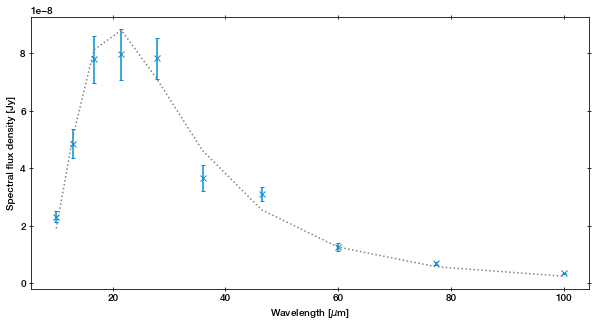

In [6]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
plt.plot(wavelength, y_true, ':', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


## Prior

Here we intentionally set very wide priors:

* a uniform prior on temperature, and 
* a very wide log-uniform prior on the normalisation.

In [7]:
def prior_transform(x):
    z = x.copy()
    z[0] = x[0]
    z[1] = 10**(x[1] * 20 - 10)
    return z


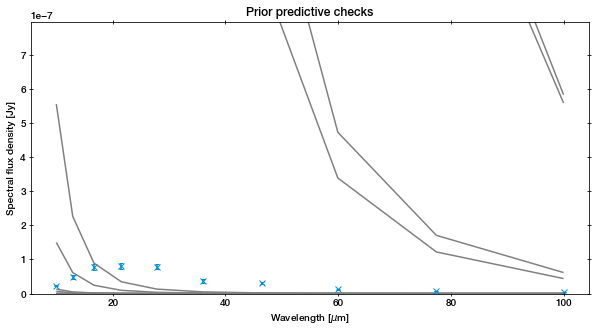

In [8]:
plt.figure(figsize=(10, 5))
plt.title("Prior predictive checks")
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
plt.ylim(0, y_obs.max() * 10)

for i in range(20):
    T, ampl = prior_transform(np.random.uniform(size=len(parameters)))
    y_predicted = black_body_model(wavelength, ampl, T)
    plt.plot(wavelength, y_predicted, '-', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


# First simple model

In [9]:
def log_likelihood(params):
    T, ampl = params
    y_predicted = black_body_model(wavelength, ampl, T)
    return scipy.stats.norm(y_predicted, sigma).logpdf(y_obs).sum()


In [10]:
from ultranest import ReactiveNestedSampler

reference_run_folder = 'blackbody-alldata'
sampler_ref = ReactiveNestedSampler(parameters, log_likelihood, prior_transform, log_dir=reference_run_folder, resume='overwrite')
results_ref = sampler_ref.run(frac_remain=0.5)
sampler_ref.print_results()


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=2e+02  7 [173.8606..173.8613]*| it/evals=6000/22771 eff=26.8204% N=400    400  400 400 
[ultranest] Likelihood function evaluations: 22781
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 159.9 +- 0.124
[ultranest] Effective samples strategy satisfied (ESS = 981.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.42, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.41 total:0.42 required:<0.50
[ultranest] done iterating.

logZ = 159.914 +- 0.447
  single instance: logZ = 159.914 +- 0.185
  bootstrapped   : logZ = 159.917 +- 0.189
  tail           : logZ = +- 0.405
insert order U test : converged: True correlation: inf iterations

    Temperature         : 0.00945│ ▁▁▁▁▁▁▁▂▂▂▄▄▅▆▆▆▇▇▆▇▆▅▅▃▃▂▁▁▁▁▁▁▁▁▁ ▁ │0.01038    0.00989 +- 0.00012
    Am

## Plot the fit

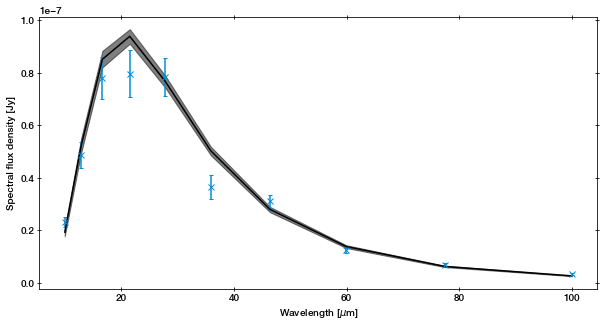

In [11]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
from ultranest.plot import PredictionBand
band = PredictionBand(wavelength)
for T, ampl in results_ref['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='k')
band.shade(color='k', alpha=0.5)
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


# Warm Start with Model modification

Lets say we alter our model slightly. We include a small constant background:

In [12]:
def log_likelihood_with_background(params):
    T, ampl = params
    y_predicted = black_body_model(wavelength, ampl, T) + 1e-9
    return scipy.stats.norm(y_predicted, sigma).logpdf(y_obs).sum()


We have the same parameters, and expect results to only be slightly different. So lets use **warm start**.

Using the previous reference run output file ...

In [13]:
posterior_upoints_file = reference_run_folder + '/chains/weighted_post_untransformed.txt'

We define our accelerated likelihood and prior transform:

In [14]:
from ultranest.integrator import warmstart_from_similar_file

aux_paramnames, aux_log_likelihood, aux_prior_transform, vectorized = warmstart_from_similar_file(
    posterior_upoints_file, parameters, log_likelihood_with_background, prior_transform)


Make accelerated run:

In [15]:
sampler = ReactiveNestedSampler(aux_paramnames, aux_log_likelihood, aux_prior_transform, vectorized=vectorized)
res = sampler.run(frac_remain=0.5)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=2e+02  6 [169.4148..169.4161]*| it/evals=1626/5461 eff=32.1280% N=400 00 
[ultranest] Likelihood function evaluations: 5484
[ultranest]   logZ = 166.7 +- 0.05516
[ultranest] Effective samples strategy satisfied (ESS = 485.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.41, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.41 total:0.41 required:<0.50
[ultranest] done iterating.


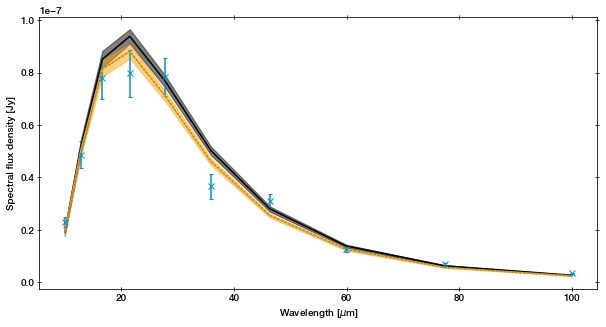

In [16]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
from ultranest.plot import PredictionBand
band = PredictionBand(wavelength)
for T, ampl in results_ref['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='k')
band.shade(color='k', alpha=0.5)

band = PredictionBand(wavelength)
for T, ampl, _ in res['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='orange')
band.shade(color='orange', alpha=0.5)
plt.plot(wavelength, y_true, ':', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


## Speed-up

In [17]:
print("Speed-up of warm-start: %d%%" % ((results_ref['ncall'] / res['ncall'] - 1)*100))

Speed-up of warm-start: 315%


The cost savings are higher, the more similar the posterior of the modified run is to the original run. This speed-up increases drastically if you have highly informative posteriors.
This benefit is *independent of problem dimension*.

## How it works & Limitations

Warm-starting works by deforming the parameter space. The prior transform function is adjusted, and the adjustment is removed by reweighting the likelihood function, to produce the same posterior.
To make this work, posterior samples from the unit cube space are required. The deformation uses a factorized auxiliary distribution, based on marginal posterior quantiles.

The weighted_post_untransformed.txt file from a hot-started run cannot be used. This is because it has a deformation already applied.


Read the full documentation at
* [warmstart_from_similar_file](https://johannesbuchner.github.io/UltraNest/ultranest.html#ultranest.integrator.warmstart_from_similar_file ) and
* the underlying [get_auxiliary_contbox_parameterization](https://johannesbuchner.github.io/UltraNest/ultranest.html#ultranest.hotstart.get_auxiliary_contbox_parameterization) function

# Starting from existing posterior samples


If you already have posterior samples, then you can create an appropriate weighted_post_untransformed.txt file.
However, the inverse of the prior transformation has to be applied.

In some cases, this is easy to do analytically, e.g., for uniform priors it is just a scaling.

The following code works for arbitrary, factorized priors (as in the blackbody example in this notebook), for an arbitrary number of parameters.

Lets start with our posterior samples. These could be obtained posterior samples from MCMC, or generated from the parameter errors quoted in a paper. Here we take it from the reference run:

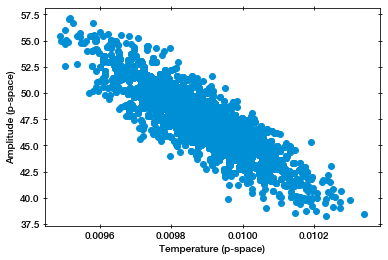

In [18]:
posterior_samples = results_ref['samples']

plt.scatter(posterior_samples[:,0], posterior_samples[:,1]);
plt.xlabel('%s (p-space)' % parameters[0])
plt.ylabel('%s (p-space)' % parameters[1]);


Lets have a look how our unit-cube prior transform works:

The first parameter has a uniform prior, the other a log-uniform prior.

In [19]:
uguess = np.linspace(1e-6, 1-1e-6, 40000)
pguess = np.array([prior_transform(ui * np.ones(len(parameters))) for ui in uguess])

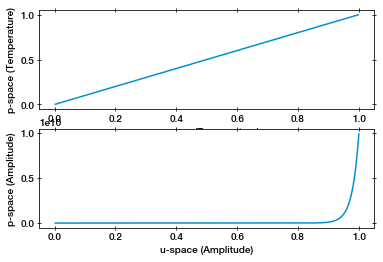

In [20]:
plt.subplot(2, 1, 1)
plt.plot(uguess, pguess[:,0])
plt.xlabel('u-space (%s)' % parameters[0])
plt.ylabel('p-space (%s)' % parameters[0]);
plt.subplot(2, 1, 2)
plt.plot(uguess, pguess[:,1])
plt.xlabel('u-space (%s)' % parameters[1])
plt.ylabel('p-space (%s)' % parameters[1]);

Here we convert the posterior samples to u-space, by finding the unit-cube value by optimization.

In [21]:
import scipy.optimize

In [22]:
import tqdm

In [23]:
nparams = len(parameters)
u = np.ones(nparams) * 0.5
stdevs = posterior_samples.std(axis=0)

def minfunc(ui, i, u, pi):
    u[i] = ui
    p = prior_transform(u)
    return (p[i] - pi)**2

usamples = np.empty((len(posterior_samples), nparams))
for j, sample in enumerate(tqdm.tqdm(posterior_samples)):
    for i, param in enumerate(parameters):
        ui0 = np.interp(sample[i], pguess[:,i], uguess)
        result = scipy.optimize.minimize_scalar(
            minfunc, 
            args=(i, u, sample[i]), 
            method='brent',
            bounds=(0,1),
            bracket=(ui0 - 1e-4, ui0, ui0 + 1e-4),
            tol=0.001 * stdevs[i],
        )
        usamples[j,i] = result.x

100%|█████████████████████████████████████| 6410/6410 [00:01<00:00, 4262.71it/s]


Lets see whether our untransformed (u-space) posterior samples are correct:

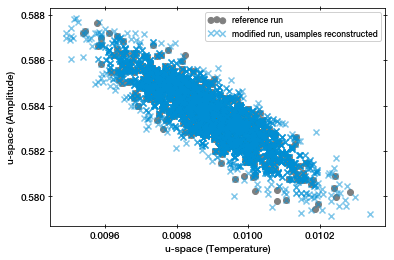

In [24]:
weights = results_ref['weighted_samples']['weights']
i = np.random.choice(len(weights), p=weights, size=1000)
plt.scatter(results_ref['weighted_samples']['upoints'][i,0], results_ref['weighted_samples']['upoints'][i,1], 
            color='gray', label='reference run');

plt.scatter(usamples[:,0], usamples[:,1], label='modified run, usamples reconstructed', marker='x', alpha=0.5)
plt.xlabel('u-space (%s)' % parameters[0])
plt.ylabel('u-space (%s)' % parameters[1])
plt.legend();

This looks like great agreement! We successfully untransformed the posterior samples to u-space.

### Writing a run file for warm start

We write a weighted_post_untransformed.txt file based on our untransformed posterior samples. Since these are equally weighted, the first two columns are constants.

In [25]:
weights = np.ones((len(usamples), 1)) / len(usamples)
logl = np.zeros(len(usamples)).reshape((-1, 1))

np.savetxt(
    'custom-weighted_post_untransformed.txt',
    np.hstack((weights, logl, usamples)),
    header=' '.join(['weight', 'logl'] + parameters),
    fmt='%f'
)

In [26]:
!head custom-weighted_post_untransformed.txt

# weight logl Temperature Amplitude
0.000156 0.000000 0.009827 0.584641
0.000156 0.000000 0.009769 0.585080
0.000156 0.000000 0.009959 0.581489
0.000156 0.000000 0.009796 0.584856
0.000156 0.000000 0.009792 0.584156
0.000156 0.000000 0.009872 0.583356
0.000156 0.000000 0.009916 0.582792
0.000156 0.000000 0.009762 0.584928
0.000156 0.000000 0.010057 0.582260


We can now point the warmstart_from_similar_file function at this file.

## Conclusion

Warm start allows accelerated computation based on already knowing the posterior peak approximately. This allows you to:

* vary the data (change the analysis pipeline)
* vary model assumptions 

without needing to start the computation from scratch (potentially costly).

These features are experimental and feedback is appreciated. It is recommended to do a full, clean run to obtain final, reliable results before publication.
